# 变分量子奇异值分解

变分量子奇异值分解（Variational Quantum Singular Value Decomposition，VQSVD）是使用量子线路实现矩阵SVD分解，复现论文 [1] 内容。

文中给出的 VASVD 算法流程如下：

![](images/vqsvd_algorithm.png)

其流程图如下：

![](images/vqsvd_diagram.png)

将相关接口封装，其中 `decompose_matrix` 实现将输入矩阵分解成算法步骤1中 $M = \sum_{k=1}^K c_k A_k$ 形式，`get_basis` 返回步骤3中的基（Computational basis），`reconstruct_by_vqsvd` 传入相关参数，重建矩阵。`VQSVDTrainer` 封装参数训练过程。下面对主体函数 `run` 进行讲解，更多细节可查看 `src/` 目录下源代码。

In [1]:
import numpy as np
from src.uitls import decompose_matrix, get_basis, reconstruct_by_vqsvd
from src.vqsvd import VQSVDTrainer


def run_demo(n_qubit, rank, ansatz_uv, in_mat, epoch=50, lr=1e-2, method='adam'):
    """Run QVSVD process with specific parameters.

    Args:
        n_qubit: number of qubit.
        rank: rank T.
        ansatz_uv: U and V ansatz circuits.
        in_mat: the input matrix.
        epoch: the epoch of training.
        lr: learning rate of optimizer.

    Return:
        re_mat: the reconstructed matrix.
    """
    # 分解矩阵
    mat_item = decompose_matrix(n_qubit, in_mat)
    # 变分线路U和V
    ansatz_u, ansatz_v = ansatz_uv
    # Algorithm 1中步骤2的正数q
    q = np.arange(rank, 0, -1)
    # 正交基底
    basis = get_basis(n_qubit, rank)
    # 封装的训练器
    vqsvd = VQSVDTrainer(n_qubit, mat_item, rank, ansatz_u, ansatz_v, q, basis,
                         lr=lr, method=method)
    # 训练参数
    vqsvd.train(epoch)
    # 重建矩阵
    re_mat = reconstruct_by_vqsvd(n_qubit, in_mat, basis, ansatz_u, ansatz_v,
                                  weight=vqsvd.weight)
    return re_mat

下面以重建一个 `8 x 8` 的矩阵为例，说明函数使用。

100%|██████████| 200/200 [01:53<00:00,  1.76it/s]


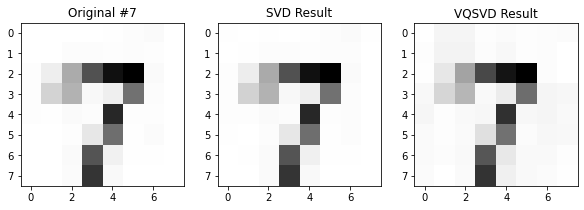

In [11]:
import matplotlib.pyplot as plt
from src.uitls import reconstruct_by_svd, get_ansatz


def demo():
    n_qubit = 3           # 量子比特数
    depth = 20            # 线路深度
    rank = 5              # 使用的秩数
    max_epoch = 200       # 最大迭代次数
    lr = 0.01             # 学习率
    # 读取图片，大小为 8x8
    in_mat = plt.imread('images/digit7_8x8.png')

    # 使用经典 SVD 重建图片
    re_mat_svd = reconstruct_by_svd(in_mat, rank)
    # 使用 VQSVD 重建图片
    ansatz_uv = get_ansatz(n_qubit, depth)
    re_mat = run_demo(n_qubit, rank, ansatz_uv, in_mat,
                      epoch=max_epoch, lr=lr)
    # 绘图
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(in_mat, cmap='gray')
    plt.title("Original #7")
    plt.subplot(1, 3, 2)
    plt.imshow(re_mat_svd, cmap='gray')
    plt.title("SVD Result")
    plt.subplot(1, 3, 3)
    plt.imshow(re_mat, cmap='gray')
    plt.title("VQSVD Result")
    plt.show()


demo()

## 论文图片复现

论文中其他图像复现代码如下：

In [ ]:
from src.demo import plot_figure4, plot_figure5, plot_figure7, plot_figure7_light


# 复现论文图4

plot_figure4()

- 运行 `plot_figure4()`，论文 Fig.4 复现结果如下：

![](images/figure4_bak.png)



- 运行 `plot_figure5(n_qubit=3)`, 使用 VQSVD 重建 `8 x 8` 矩阵，在 8u32G cpu 耗时大约 6 分钟。如果运行 `plot_figure5(n_qubit=5)` 则重建 `32 x 32` 矩阵，此时可能比较耗时，在 8u32G cpu 耗时大约 3 个小时。运行 `plot_figure5(n_qubit=3)` 结果如下，可以看到此时 VQSVD 能很好重建原图像。

![](images/figure5_8x8_bak.png)

- 运行 `plot_figure7_light()`，复现结果如下图，可见相同参数数目下线路 (a) 效果最好。`plot_figure7_light` 采用 scipy 的 BFGS 优化器优化，`plot_figure7` 使用 mindspore 的 Adam 优化器优化，前者收敛速度更快。

![](images/figure7_bak.png)


## 其他改进

复现论文中 Figure.5 结果，图片大小为 `32x32` 时速度较慢，通过使用 BFGS 优化器加快收敛，另外通过获取量子态直接计算期望值，而不是通过将矩阵分解成哈密顿量再逐项计算，可以有效提高计算速度。需要说明的是，使用量子态直接计算期望值是仅在模拟器中演示算法总体可行性，现实中无法获得量子真实状态。通过改进，算法速度提高 6 倍左右，使用方法为 `plot_figure5_light`，其底层通过 `scipy.optimize.minimize` 封装，具体内容见函数 `utils.run_light`。

In [ ]:
from src.demo import plot_figure5_light


plot_figure5_light()

复现结果如下，可见 VQSVD 成功重建图像。

![](images/figure5_bak.png)

## 参考文献

[1] Wang, X., Song, Z., & Wang, Y. (2021). Variational Quantum Singular Value Decomposition. Quantum, 5, 483.